In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

In [2]:
# Replace 'filename.csv' with the path to your CSV file
icici_bank_history = '300000/Shares/ICICIBANK-EQ-22-06-2024-to-22-06-2025.csv'

# Read the CSV file into a DataFrame
icici_bank = pd.read_csv(icici_bank_history)

# Print the DataFrame
icici_bank = icici_bank['Open']

# ---------------------------------------------

# Replace 'filename.csv' with the path to your CSV file
hal_history = '300000/Shares/HAL-EQ-22-06-2024-to-22-06-2025.csv'

# Read the CSV file into a DataFrame
hal = pd.read_csv(hal_history)

# Print the DataFrame
hal = hal['Open']

# ---------------------------------------------

# Replace 'filename.csv' with the path to your CSV file
pb_fintech_history = '300000/Shares/POLICYBZR-EQ-22-06-2024-to-22-06-2025.csv'

# Read the CSV file into a DataFrame
pb_fintech = pd.read_csv(pb_fintech_history)

# Print the DataFrame
pb_fintech = pb_fintech['Open']

# ---------------------------------------------

# Replace 'filename.csv' with the path to your CSV file
sun_pharma_history = '300000/Shares/SUNPHARMA-EQ-22-06-2024-to-22-06-2025.csv'

# Read the CSV file into a DataFrame
sun_pharma = pd.read_csv(sun_pharma_history)

# Print the DataFrame
sun_pharma = sun_pharma['Open']


sun_pharma.dtype

dtype('float64')

In [3]:
icici_bank = icici_bank.astype(int)

hal = hal.astype(int)

pb_fintech = pb_fintech.astype(int)

sun_pharma = sun_pharma.astype(int)

In [4]:
# Merging all Stocks in a DataFrame

df = pd.DataFrame({'icici_bank':icici_bank, 'pb_fintech': pb_fintech, 'sun_pharma':sun_pharma, 'hal':hal})
df

,icici_bank,pb_fintech,sun_pharma,hal
0,1411,1855,1647,4910
1,1408,1903,1648,5020
2,1417,1940,1645,5054
3,1426,1921,1680,5079
4,1416,1894,1665,5048
...,...,...,...,...
739,711,600,837,1807
740,728,615,828,1820
741,710,596,827,1790
742,690,585,809,1802


In [5]:
# Calculate log returns
log_returns = np.log(df / df.shift(1)).dropna()

log_returns

,icici_bank,pb_fintech,sun_pharma,hal
1,-0.002128,0.025547,0.000607,0.022156
2,0.006372,0.019256,-0.001822,0.006750
3,0.006331,-0.009842,0.021053,0.004934
4,-0.007037,-0.014155,-0.008969,-0.006122
5,-0.009223,-0.034375,0.000600,-0.029757
...,...,...,...,...
739,0.009894,0.016807,0.015654,0.015617
740,0.023629,0.024693,-0.010811,0.007168
741,-0.025036,-0.031382,-0.001208,-0.016621
742,-0.028573,-0.018629,-0.022006,0.006682


In [6]:
# Feature Engineering for Clustering

# Rolling features for clustering (30-day window)
window = 30

rolling_volatility = log_returns.rolling(window).std().mean(axis=1)   # average volatility across assets
rolling_momentum = log_returns.rolling(window).mean().mean(axis=1)    # average momentum (returns) across assets
rolling_correlation = log_returns.rolling(window).corr()

# Compute average pairwise correlation at each time
correlation_values = []
for i in range(window - 1, len(log_returns)):
    corr_matrix = rolling_correlation.iloc[i * len(log_returns.columns):(i+1) * len(log_returns.columns)]
    avg_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).mean().mean()
    correlation_values.append(avg_corr)

# Align indexes
correlation_series = pd.Series(correlation_values, index=rolling_volatility.index[-len(correlation_values):])

# Combine into features DataFrame
features = pd.DataFrame({
    'volatility': rolling_volatility[-len(correlation_values):],
    'momentum': rolling_momentum[-len(correlation_values):],
    'correlation': correlation_series
}).dropna()

In [7]:
# Scale Features

from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [8]:
# Clustering with KMeans (to detect regimes)

from sklearn.cluster import KMeans

# Apply KMeans to detect regimes
kmeans = KMeans(n_clusters=10, random_state=42)
regimes = kmeans.fit_predict(scaled_features)

# Add regime labels to the log_returns DataFrame (aligning with features index)
log_returns_regime = log_returns.loc[features.index].copy()
log_returns_regime['Regime'] = regimes


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [9]:
# Define Portfolio Optimization Function

from scipy.optimize import minimize

def optimize_portfolio(returns, risk_free_rate=0.0675):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    initial_weights = np.array([1/num_assets] * num_assets)

    def neg_sharpe(weights):
        port_return = np.dot(weights, mean_returns) * 252
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
        sharpe = (port_return - risk_free_rate) / port_vol
        return -sharpe

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [10]:
# Run Optimization by Market Regime

# Optimize portfolio for each market regime
optimized_weights_by_regime = {}

for regime in np.unique(regimes):
    regime_data = log_returns_regime[log_returns_regime['Regime'] == regime].drop(columns='Regime')
    weights = optimize_portfolio(regime_data)
    optimized_weights_by_regime[regime] = weights
    print(f"\n📈 Regime {regime} Optimal Weights:")
    for asset, weight in zip(regime_data.columns, weights):
        print(f"{asset}: {weight:.4f}")


📈 Regime 0 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 1.0000
sun_pharma: 0.0000
hal: 0.0000

📈 Regime 1 Optimal Weights:
icici_bank: 0.2522
pb_fintech: 0.0000
sun_pharma: 0.0000
hal: 0.7478

📈 Regime 2 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 0.0000
sun_pharma: 0.0000
hal: 1.0000

📈 Regime 3 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 0.0000
sun_pharma: 0.0000
hal: 1.0000

📈 Regime 4 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 0.0348
sun_pharma: 0.0000
hal: 0.9652

📈 Regime 5 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 0.0000
sun_pharma: 1.0000
hal: 0.0000

📈 Regime 6 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 1.0000
sun_pharma: 0.0000
hal: 0.0000

📈 Regime 7 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 1.0000
sun_pharma: 0.0000
hal: 0.0000

📈 Regime 8 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 1.0000
sun_pharma: 0.0000
hal: 0.0000

📈 Regime 9 Optimal Weights:
icici_bank: 0.0000
pb_fintech: 1.0000
sun_pharma: 0.0000
hal: 0.0000


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


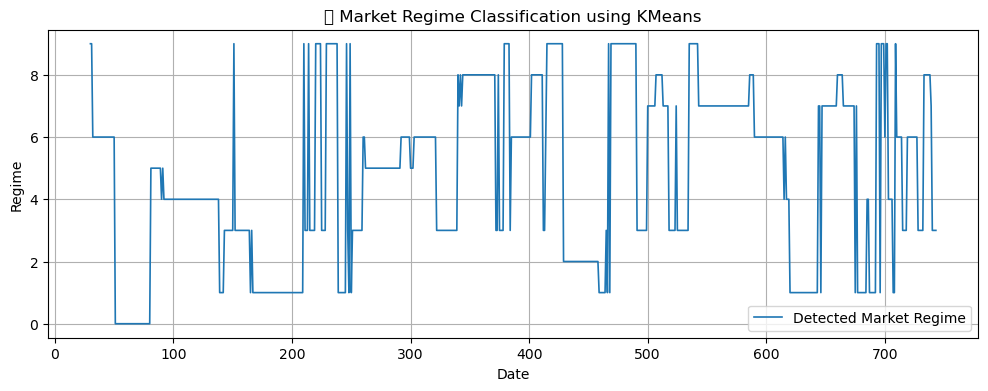

In [11]:
# Visualize Market Regimes

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(log_returns_regime.index, log_returns_regime['Regime'], label='Detected Market Regime', lw=1.2)
plt.title("📊 Market Regime Classification using KMeans")
plt.xlabel("Date")
plt.ylabel("Regime")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# Use the latest regime to dynamically choose weights:

current_regime = regimes[-1]
portfolio_weights = optimized_weights_by_regime[current_regime]
 
portfolio_weights

16.5431

array([5.55111512e-16, 9.99200722e-16, 0.00000000e+00, 1.00000000e+00])